In [3]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

In [24]:
from load_librairies import *
from scipy.stats.stats import pearsonr
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy
from shapely.geometry import Polygon
def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x
    return y_detrended


def is_mjj(month):
    return (month>=5) & (month<=7)

def is_mam(month):
    return (month>=3) & (month<=5)

def is_jja(month):
    return (month>=6) & (month<=8)

def is_nd(month):
    return (month==11) | (month==12)


dir_proj = '/home/netapp-clima-users/users/aprigent/Projects/TAV_OMIP/'
path_fig = dir_proj+'/figures_final/'
path_data_out = '/media/aprigent/Arthur_disk/data_uncertainty/'


dir_tos_omip1 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/'
dir_tos_omip2 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/'
dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/'

period_str = 1985
period_end = 2004
%matplotlib inline



/tmp/ipykernel_3349/2612102012.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# ORA-S5

In [6]:

sst_oras5_tmp = xr.open_dataset(dir_obs_sst+'ORA-S5/sosstsst_merged_r360x180_oras5_1984_2005_global.nc')
sst_oras5_tmp = sst_oras5_tmp.sosstsst[:] # K to degC
sst_oras5 = sst_oras5_tmp.sel(time_counter=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
sst_oras5_arr = np.array(sst_oras5)
sst_oras5_atl_dtd = np.ones((sst_oras5_arr.shape))*np.nan
for i in range(sst_oras5_atl_dtd.shape[1]):
    for j in range(sst_oras5_atl_dtd.shape[2]):
        sst_oras5_atl_dtd[:,i,j] = nandetrend(sst_oras5_arr[:,i,j])
        
        
sst_oras5_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_oras5_atl_dtd)}
                       ,coords={'time':np.array(sst_oras5.time_counter),
                                'lon':np.array(sst_oras5.lon),
                                'lat':np.array(sst_oras5.lat)
                                })


sst_oras5_atl_dtd_xarray = sst_oras5_atl_dtd_xarray.where((sst_oras5_atl_dtd_xarray.lat>-60)&
                                    (sst_oras5_atl_dtd_xarray.lat<60),drop=True)



In [7]:
ssta_oras5_atl_dtd,_ = Atools.ano_norm_t(sst_oras5_atl_dtd_xarray.sst_dtd)

std_ssta_oras5_atl_dtd = ssta_oras5_atl_dtd.std(dim='time')


In [8]:
std_ssta_oras5_atl_dtd = xr.concat([std_ssta_oras5_atl_dtd[:,180:],
                                   std_ssta_oras5_atl_dtd[:,:180]],dim = 'lon') 
std_ssta_oras5_atl_dtd.coords['lon'] = (std_ssta_oras5_atl_dtd.coords['lon'] + 180)%360 - 180

# Check

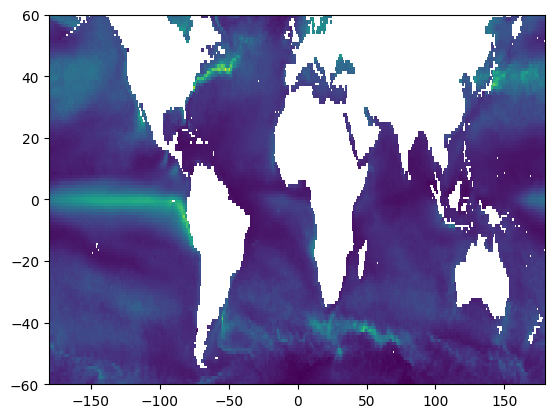

In [9]:
plt.pcolor(std_ssta_oras5_atl_dtd.lon,std_ssta_oras5_atl_dtd.lat,std_ssta_oras5_atl_dtd[:,:])

# OMIP models

In [11]:
omip1_models = pd.read_csv(dir_proj+'/scripts/omip1_models_for_BF_zos.txt',header=None,delimiter=',')
omip1_models = omip1_models[0].values.tolist()
print(omip1_models)


omip2_models = pd.read_csv(dir_proj+'/scripts/omip2_models_for_BF_zos.txt',header=None,delimiter=',')
omip2_models = omip2_models[0].values.tolist()
print(omip2_models)

['CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']
['ACCESS-OM2', 'ACCESS-OM2-025', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3', 'MRI-ESM2-0', 'NorESM2-LM']


In [12]:
def get_sst_omip1_atl(directory,model):
    print(directory+model+'/r1i1p1f1/global/*.nc')
    sst_omip1 = xr.open_dataset(
        directory+model+'/r1i1p1f1/global/tos_merged_standard_'+str(model)+'_r360x180_global.nc',
        use_cftime=True)
    sst_omip1 = sst_omip1.tos[4*744:5*744,:,:]
    time_new = pd.date_range('1948-01-15', freq='M',periods=sst_omip1.time.shape[0])
    sst_omip1['time'] = time_new
    sst_omip1 = sst_omip1.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
    
    #sst_omip1_atl = Atools.data_sub(sst_omip1,-45,20,-30,10)
    
    sst_omip1_trop = sst_omip1.where((sst_omip1.lat>-60)&(sst_omip1.lat<60),drop=True)
    
    sst_omip1_atl_arr = np.array(sst_omip1_trop)
    sst_omip1_atl_dtd = np.ones((sst_omip1_atl_arr.shape))*np.nan
    for i in range(sst_omip1_trop.shape[1]):
        for j in range(sst_omip1_trop.shape[2]):
            sst_omip1_atl_dtd[:,i,j] = nandetrend(sst_omip1_atl_arr[:,i,j])
             

    sst_omip1_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_omip1_atl_dtd)}
                       ,coords={'time':np.array(sst_omip1_trop.time),
                                'lon':np.array(sst_omip1_trop.lon),
                                'lat':np.array(sst_omip1_trop.lat)
                                })
    
    
    ssta_omip1_atl_dtd,_ = Atools.ano_norm_t(sst_omip1_atl_dtd_xarray.sst_dtd)

    return ssta_omip1_atl_dtd,sst_omip1_atl_dtd_xarray.sst_dtd


def get_sst_omip2_atl(directory,model):
    print(directory+model+'/r1i1p1f1/global/*.nc')
    sst_omip1 = xr.open_dataset(
        directory+model+'/r1i1p1f1/global/tos_merged_standard_'+str(model)+'_r360x180_global.nc',use_cftime=True)
    sst_omip1 = sst_omip1.tos[-732:,:,:]
    time_new = pd.date_range('1958-01-15', freq='M',periods=sst_omip1.time.shape[0])
    sst_omip1['time'] = time_new
    sst_omip1 = sst_omip1.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
    
    
    sst_omip1_trop = sst_omip1.where((sst_omip1.lat>-60)&(sst_omip1.lat<60),drop=True)
    sst_omip1_atl_arr = np.array(sst_omip1_trop)
    sst_omip1_atl_dtd = np.ones((sst_omip1_atl_arr.shape))*np.nan
    for i in range(sst_omip1_trop.shape[1]):
        for j in range(sst_omip1_trop.shape[2]):
            sst_omip1_atl_dtd[:,i,j] = nandetrend(sst_omip1_atl_arr[:,i,j])
             

    sst_omip1_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_omip1_atl_dtd)}
                       ,coords={'time':np.array(sst_omip1_trop.time),
                                'lon':np.array(sst_omip1_trop.lon),
                                'lat':np.array(sst_omip1_trop.lat)
                                })
    
    
    ssta_omip1_atl_dtd,_ = Atools.ano_norm_t(sst_omip1_atl_dtd_xarray.sst_dtd)

    return ssta_omip1_atl_dtd,sst_omip1_atl_dtd_xarray.sst_dtd

# Loop OMIP1 models

In [13]:
test,_ = get_sst_omip1_atl(dir_tos_omip1,omip1_models[2])


/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/EC-Earth3/r1i1p1f1/global/*.nc


In [14]:
ssta_omip1_atl = np.ones((len(omip1_models),test.shape[0],test.shape[1],test.shape[2]))*np.nan
sst_omip1_atl = np.ones((len(omip1_models),test.shape[0],test.shape[1],test.shape[2]))*np.nan
for i in range(len(omip1_models)):
    ssta_omip1_atl[i,:,:,:],sst_omip1_atl[i,:,:,:]= get_sst_omip1_atl(dir_tos_omip1,omip1_models[i])

/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/CMCC-CM2-SR5/r1i1p1f1/global/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/CMCC-ESM2/r1i1p1f1/global/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/EC-Earth3/r1i1p1f1/global/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/IPSL-CM6A-LR/r1i1p1f1/global/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/MRI-ESM2-0/r1i1p1f1/global/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/NorESM2-LM/r1i1p1f1/global/*.nc


In [15]:
ssta_omip1_global_all  = xr.Dataset({'ssta': (['model','time','lat','lon'],ssta_omip1_atl),
                                  'sst': (['model','time','lat','lon'],sst_omip1_atl)}
                       ,coords={'model':np.array(omip1_models),
                                'time':np.array(test.time),
                                'lon': np.array(test.lon),
                                'lat': np.array(test.lat)
                                })
ssta_omip1_global_all = xr.concat([ssta_omip1_global_all.ssta[:,:,:,180:],
                                   ssta_omip1_global_all.ssta[:,:,:,:180]],dim = 'lon') 
ssta_omip1_global_all.coords['lon'] = (ssta_omip1_global_all.coords['lon'] + 180)%360 - 180

In [16]:
std_ssta_omip1_global_all = np.sqrt(ssta_omip1_global_all.var(dim='time').mean(dim='model'))

In [17]:
#ssta_omip1_atl_all.to_netcdf(path_data_out+'sst_ssta_omip1_atl_1985_2004.nc','w')

# Loop on OMIP2 models

In [18]:
test2,_ = get_sst_omip2_atl(dir_tos_omip2,omip2_models[0])


/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/ACCESS-OM2/r1i1p1f1/global/*.nc


In [19]:
ssta_omip2_atl = np.ones((len(omip2_models),test2.shape[0],test2.shape[1],test2.shape[2]))*np.nan
sst_omip2_atl = np.ones((len(omip2_models),test2.shape[0],test2.shape[1],test2.shape[2]))*np.nan
for i in range(len(omip2_models)):
    print(omip2_models[i])
    ssta_omip2_atl[i,:,:,:],sst_omip2_atl[i,:,:,:]= get_sst_omip2_atl(dir_tos_omip2,omip2_models[i])

ACCESS-OM2
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/ACCESS-OM2/r1i1p1f1/global/*.nc
ACCESS-OM2-025
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/ACCESS-OM2-025/r1i1p1f1/global/*.nc
CMCC-CM2-HR4
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/CMCC-CM2-HR4/r1i1p1f1/global/*.nc
CMCC-CM2-SR5
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/CMCC-CM2-SR5/r1i1p1f1/global/*.nc
EC-Earth3
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/EC-Earth3/r1i1p1f1/global/*.nc
MRI-ESM2-0
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/MRI-ESM2-0/r1i1p1f1/global/*.nc
NorESM2-LM
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/NorESM2-LM/r1i1p1f1/global/*.nc


In [20]:
ssta_omip2_global_all  = xr.Dataset({'ssta': (['model','time','lat','lon'],ssta_omip2_atl),
                                 'sst': (['model','time','lat','lon'],sst_omip2_atl)}
                       ,coords={'model':np.array(omip2_models),
                                'time':np.array(test2.time),
                                'lon': np.array(test2.lon),
                                'lat': np.array(test2.lat)
                                })

ssta_omip2_global_all = xr.concat([ssta_omip2_global_all.ssta[:,:,:,180:],
                                   ssta_omip2_global_all.ssta[:,:,:,:180]],dim = 'lon') 
ssta_omip2_global_all.coords['lon'] = (ssta_omip2_global_all.coords['lon'] + 180)%360 - 180

In [21]:
std_ssta_omip2_atl_all = np.sqrt(ssta_omip2_global_all.var(dim='time').mean(dim='model'))

# CMIP6

In [22]:
sst_dtd_cmip6 = xr.open_dataset('/media/aprigent/Arthur_disk/TAV_OMIP/std_ssta_cmip6_hist_for_OMIP.nc')

ssta_dtd_cmip6 = sst_dtd_cmip6.ssta.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))



ssta_dtd_cmip6_mjj = ssta_dtd_cmip6.sel(time=is_mjj(
    ssta_dtd_cmip6['time.month'])).groupby('time.year').mean()

In [23]:
std_ssta_dtd_cmip6_mjj_mean = np.sqrt(ssta_dtd_cmip6_mjj.var(dim='year').mean(dim='model'))

# Figure 1 

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_lab

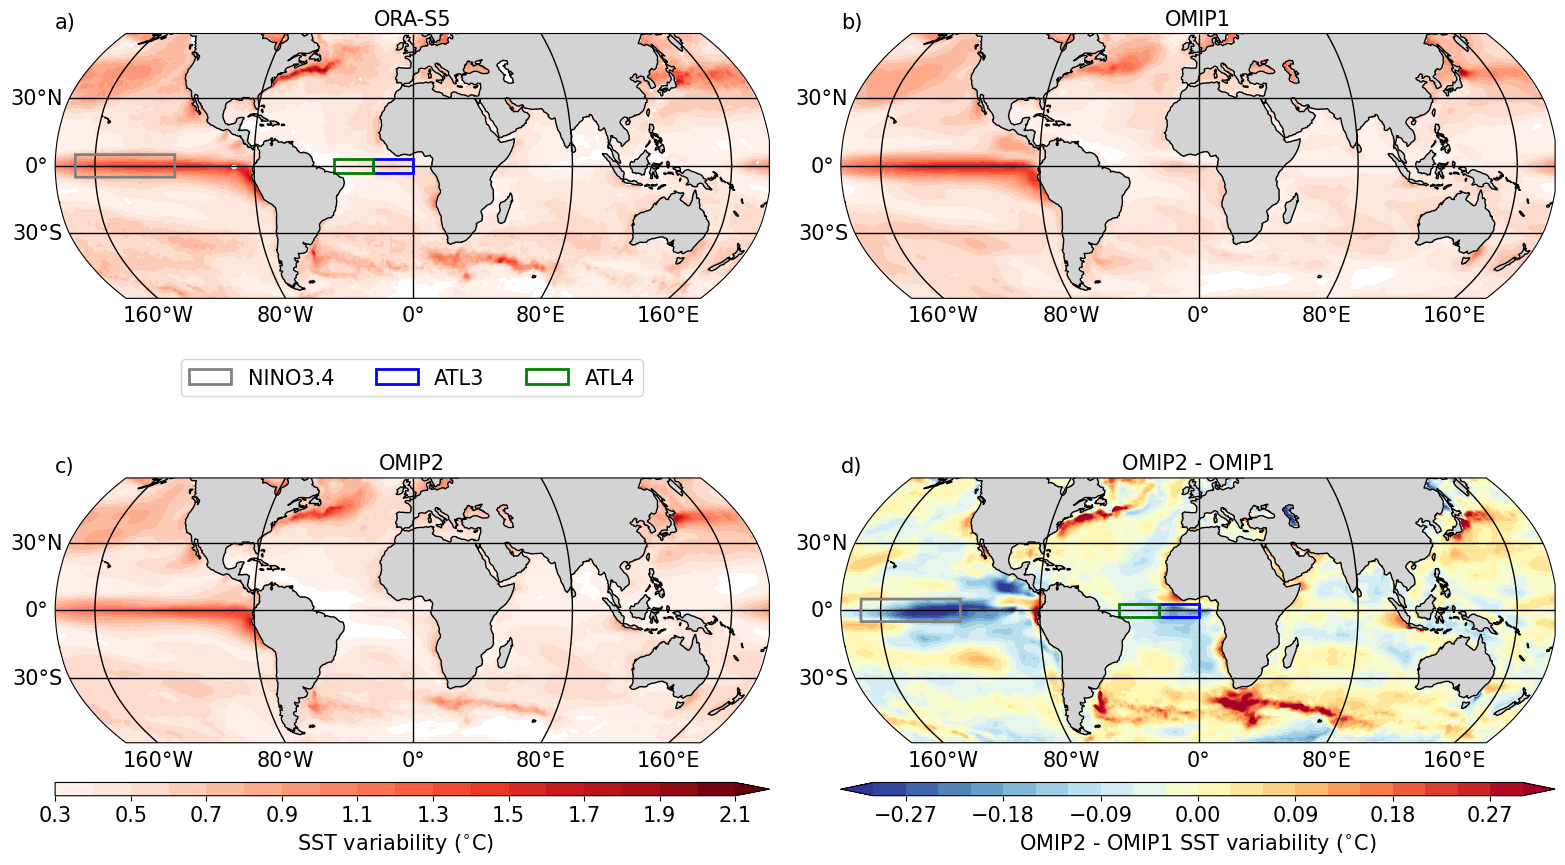

In [25]:
ftz=15
f,ax = plt.subplots(2,2,figsize=[15,10], subplot_kw={'projection': ccrs.Robinson()})
f.patch.set_facecolor('white')
m = np.arange(1,13,1)
ax = ax.ravel()

plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=-0.2, wspace=0.1)
levels = np.arange(0.3,2.2,0.1)
cmap = plt.cm.Reds


levels1 = np.arange(-0.3,0.33,0.03)
cmap1 = plt.cm.RdYlBu_r



cax0 = inset_axes(ax[2],
                 width='100%',
                 height='5%',
                 loc = 'lower left',
                 bbox_to_anchor=(0,-0.2,1,1),
                 bbox_transform=ax[2].transAxes,
                 borderpad=0)

cax2 = inset_axes(ax[3],
                 width='100%',
                 height='5%',
                 loc = 'lower left',
                 bbox_to_anchor=(0,-0.2,1,1),
                 bbox_transform=ax[3].transAxes,
                 borderpad=0)




p0 = ax[0].contourf(std_ssta_oras5_atl_dtd.lon,
               std_ssta_oras5_atl_dtd.lat,
               std_ssta_oras5_atl_dtd,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')

gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-160,-80,0,80,160])
gl.ylocator = mticker.FixedLocator([-30,0,30])
ax[0].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[0].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[0].set_title('ORA-S5',fontsize=ftz)

ax[0].add_patch(mpatches.Rectangle(xy=[190,-5],
                                   width=50,
                                   height=10,
                                   edgecolor='grey',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='NINO3.4',transform=ccrs.PlateCarree()))


ax[0].add_patch(mpatches.Rectangle(xy=[340,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3',transform=ccrs.PlateCarree()))
ax[0].add_patch(mpatches.Rectangle(xy=[320,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='green',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL4',transform=ccrs.PlateCarree()))

ax[0].legend(loc='center',bbox_to_anchor=(0.5, -0.3),ncol=3,fontsize=ftz)

p0 = ax[1].contourf(std_ssta_omip1_global_all.lon,
               std_ssta_omip1_global_all.lat,
               std_ssta_omip1_global_all,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')

gl = ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-160,-80,0,80,160])
gl.ylocator = mticker.FixedLocator([-30,0,30])
ax[1].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[1].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[1].set_title('OMIP1',fontsize=ftz)
cbar = plt.colorbar(p0,cax0,orientation='horizontal')
cbar.ax.tick_params(labelsize=ftz)
cbar.set_label('SST variability ($^{\circ}$C)',fontsize=ftz)


p0 = ax[2].contourf(std_ssta_omip2_atl_all.lon,
               std_ssta_omip2_atl_all.lat,
               std_ssta_omip2_atl_all,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')

ax[2].set_title('OMIP2',fontsize=ftz)
gl = ax[2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-160,-80,0,80,160])
gl.ylocator = mticker.FixedLocator([-30,0,30])
ax[2].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[2].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines




ax[3].set_title('OMIP2 - OMIP1', fontsize=ftz)
p2 = ax[3].contourf(std_ssta_omip2_atl_all.lon,
               std_ssta_omip2_atl_all.lat,
               std_ssta_omip2_atl_all - std_ssta_omip1_global_all,
               cmap = cmap1,
               levels = levels1,transform=ccrs.PlateCarree(),extend='both')


gl = ax[3].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-160,-80,0,80,160])
gl.ylocator = mticker.FixedLocator([-30,0,30])
ax[3].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[3].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines

cbar = plt.colorbar(p2,cax2,orientation='horizontal')
cbar.ax.tick_params(labelsize=ftz)
cbar.set_label('OMIP2 - OMIP1 SST variability ($^{\circ}$C)',fontsize=ftz)


ax[3].add_patch(mpatches.Rectangle(xy=[190,-5],
                                   width=50,
                                   height=10,
                                   edgecolor='grey',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='NINO3.4',transform=ccrs.PlateCarree()))

ax[3].add_patch(mpatches.Rectangle(xy=[340,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3',transform=ccrs.PlateCarree()))
ax[3].add_patch(mpatches.Rectangle(xy=[320,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='green',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL4',transform=ccrs.PlateCarree()))




ax[0].text(0,1.02,'a)',transform=ax[0].transAxes,size=ftz)
ax[1].text(0,1.02,'b)',transform=ax[1].transAxes,size=ftz)
ax[2].text(0,1.02,'c)',transform=ax[2].transAxes,size=ftz)
ax[3].text(0,1.02,'d)',transform=ax[3].transAxes,size=ftz)


plt.savefig(path_fig+'figure_01.png',bbox_inches='tight',dpi=300)